# Comparison of SK Learn Decision Tree Classifier & Scratch Decision Tree 
by Travis Gopaul and Jacob Duncan
5/13/22

## Dataset: Suicide Rates Overview 1985 to 2016
https://www.kaggle.com/datasets/russellyates88/suicide-rates-overview-1985-to-2016/download


### Table of Contents
#### [SK Learn Implementation](#sk_alg)<br>
#### [Scratch Implementation](#scratch_alg)<br>
#### [Analysis](#analysis)

*To view the notebook with outputs, visit my Github at https://github.com/TWGopaul/COSC311/blob/main/DecisionTree_SKvScratch.ipynb *

### 1) Effectively summarize the data: what is it? what does it represent? How was it gathered?
The Dataset is compiled from collection of datasets from UN Development Program, World Bank, "Suicide in the Twenty-First Century" (dataset), and the World Health Organization

The goal is to compare socio-economic information with suicide rates to find correlations. The data represents the number of suicides per year in each country that has reported the information, including suicides/100k, gdp and hdi information. The suicide data is also labeled by age group, gender(M or F) and generation.

### 2) What classes are present in the data?
We chose to examine the classes of suicide risk which we decided to split into a high-risk class and low-risk class. Using exploratory data analysis, we observed some correlations:

Sex: males have a higher risk
Age: Adults age 35+ have a higher risk; 75+ most at risk



### 3. What attributes look like they are paramters of an underlying population that could be learned by an unsupervised machine learning algorithm?
The following attributes are parameters of an underlying population that could be learned by an unsupervised machine learning algorithm:

GDP per Capita and Population of a country can effectively model the suicide rate of that country per year?

GDP per year and Population of a country can effectively model the suicide rate of that country per year?
Age Group and Gender can effectively model the suicide rate of that country per year?
These are the different features that stood out to me as being underlying parameters that could possibly be fed to an unsupervised machine learning algorithm to predict suicide rate within a country per year.

### Visualizations

![world_map.png](./images/world_map.png)
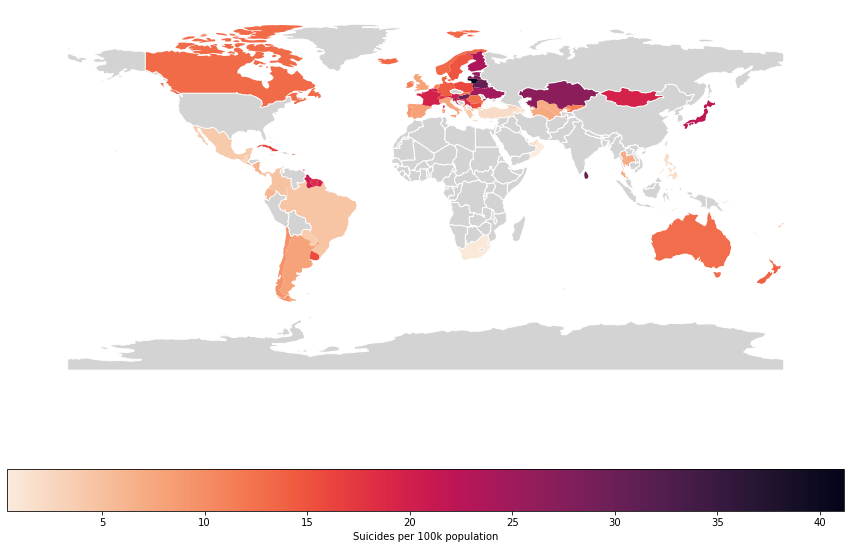

![age_sex2.png](./images/age_sex2.png)
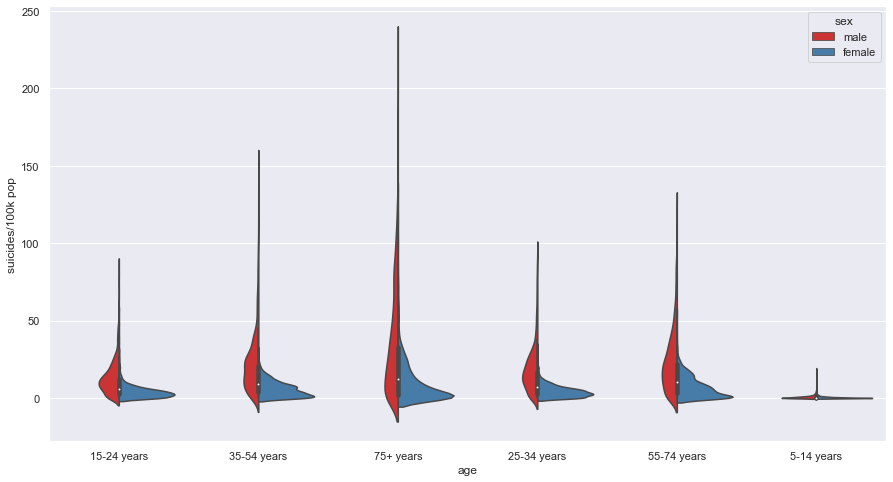

![age_rate.png](./images/age_rate.png)
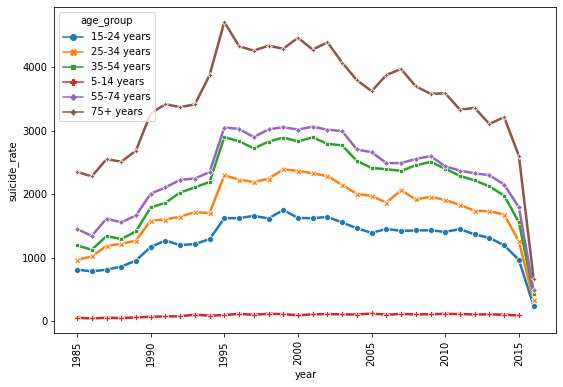

![corr.png](./images/corr.png)
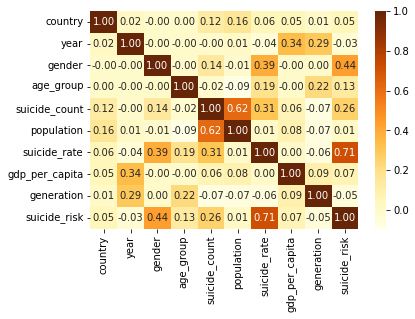

In [3]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import warnings
%matplotlib inline

In [4]:
# Read in data from kaggle
# https://www.kaggle.com/datasets/russellyates88/suicide-rates-overview-1985-to-2016/download

raw_df = pd.read_csv('../../data/suicide.csv')
raw_df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


### Data Preprocessing

In [5]:
# Remove spaces from coloumn name
raw_df.rename(columns={' gdp_for_year ($) ':'gdp_for_year ($)'}, inplace=True)
raw_df.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year', 'gdp_for_year ($)',
       'gdp_per_capita ($)', 'generation'],
      dtype='object')

One main issue with the data is the 'HDI for year' column. This feature is the Human Development Index, which could have a notable effect on the suicide risk of a population. However, there is a significant amount of rows missing entries for this column. Therefore we decided to remove it altogether so as to not skew the learning ability of the model.

In [6]:
# Drop na values in HDI
raw_df.loc[raw_df['HDI for year'].isna(), ['country', 'year']].drop_duplicates()

,country,year
0,Albania,1987
12,Albania,1988
24,Albania,1989
36,Albania,1992
48,Albania,1993
...,...,...
27688,Uzbekistan,2001
27700,Uzbekistan,2002
27712,Uzbekistan,2003
27724,Uzbekistan,2004


In [7]:
# Still missing a lot of HDI data
# Decided to drop column so as to not skew results due to missing information in some rows
raw_df.drop(["HDI for year"], axis=1)

# Also drop country-year since it is already given in the year column
raw_df.drop(columns=['country-year'], inplace=True)
raw_df.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'HDI for year', 'gdp_for_year ($)',
       'gdp_per_capita ($)', 'generation'],
      dtype='object')

Now that the data has been scrubbed, we need to create columns for our class which is the risk of suicide. For each row, if the value of 'suicides/100k' is greater than the mean of 'suicides/100k' for all rows then we'll call that a 'high' risk, if the value is less than the mean it will be labeled a 'low' risk. This will be the target column for the model.

<a id='sk_alg'></a>
## SK Learn Decision Tree



In [8]:
# Create additional column for suicide risk and set the default value as low 
raw_df['suicide_risk'] = 'low' 

# Set the risk as high if suicides/100k pop is higher than the mean, high 
# Compare the value of suicides/100k to the mean of all suicides/100k.
# If the value is lower than the mean we'll say it is a low risk, else a high risk

raw_df.loc[raw_df['suicides/100k pop'] > raw_df['suicides/100k pop'].mean(), 'suicide_risk'] = 'high' 
raw_df['suicide_risk'].value_counts()

low     19061
high     8759
Name: suicide_risk, dtype: int64

Since we have time series data and are attempting to build a machine learning model to make predictions on the future, we need to train the model on past observations. Therefore, instead of doing a randomized 80%|10%|10% train test validate split, we will split the data by time. By taking the cumulative sum / sum of years of all the data, we can see what percentage of the data hs been collected up until a particular year. Observe the list below: ~80% of the data represents years 1985 - 2009, the next ~10% is from 2010 - 2013, and the final ~10% from 2014 - 2016.

In [9]:
# Split data into 80/10/10

train_df = raw_df.loc[raw_df['year'] <= 2009]
val_df = raw_df.loc[(raw_df['year'] >= 2010) & (raw_df['year'] <=2012)]
test_df = raw_df.loc[raw_df['year'] >= 2013]

print('train_df.shape: ', train_df.shape)
print('val_df.shape: ', val_df.shape)
print('test_df.shape: ', test_df.shape)

train_df.shape:  (21960, 12)
val_df.shape:  (3060, 12)
test_df.shape:  (2800, 12)


Noting the correlellogram from earlier, the following columns won't be useful for the algorithm:
year, suicides_no, population, suicides/100k, gpd_for_year, and generation. 

In [10]:
# Label input and target columns
input_cols = ['country', 'sex', 'age', 'gdp_per_capita ($)']
target_col = 'suicide_risk'

In [11]:
train_inputs = train_df.loc[:, input_cols]
train_target = train_df.loc[:, target_col]

val_inputs = val_df.loc[:, input_cols]
val_target = val_df.loc[:, target_col]

test_inputs = test_df.loc[:, input_cols]
test_target = test_df.loc[:, target_col]


In [12]:
numeric_cols = list(train_inputs.select_dtypes(include=np.number).columns)
categorical_cols = list(train_inputs.select_dtypes(include='object').columns)

print('numeric columns: ', numeric_cols)
print('categorical columns: ', categorical_cols)

numeric columns:  ['gdp_per_capita ($)']
categorical columns:  ['country', 'sex', 'age']


The numeric features identified in the previous step need to scaled to values from 0 to 1 to prevent particular features from having a disproportionate affect on the accuracy of the model.

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Fit the scaler to all the data
scaler = MinMaxScaler().fit(raw_df.loc[:, numeric_cols])

# Scale the train, validation and test sets 
train_inputs.loc[:, numeric_cols] = scaler.transform(train_inputs.loc[:, numeric_cols])
val_inputs.loc[:, numeric_cols] = scaler.transform(val_inputs.loc[:, numeric_cols])
test_inputs.loc[:, numeric_cols] = scaler.transform(test_inputs.loc[:, numeric_cols])



Finally, we need to encode the categorical columns into values of either 0 or 1 in order to use them in the algorithm.

In [14]:
# Check the number of unique values of each categorical column
raw_df[categorical_cols].nunique()

country    101
sex          2
age          6
dtype: int64

In [15]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore').fit(raw_df[categorical_cols])

*Note : the encoder used seems to raise some "DataFrame fragmented" warnings. This can cause performance issues for extremely large datasets, but has not made a significant effect on this analysis.*

In [16]:
encoded_cols = list(encoder.get_feature_names(categorical_cols))

# Encode the columns
train_inputs[encoded_cols] = encoder.transform(train_inputs.loc[:, categorical_cols]).toarray()
val_inputs[encoded_cols] = encoder.transform(val_inputs.loc[:, categorical_cols]).toarray()
test_inputs[encoded_cols] = encoder.transform(test_inputs.loc[:, categorical_cols]).toarray()

/opt/homebrew/Caskroom/miniforge/base/envs/env-01/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/var/folders/t4/ybx0qpc17lgbs28t98mp2wk40000gn/T/ipykernel_38988/2917261160.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs.loc[:, categorical_cols]).toarray()
/var/folders/t4/ybx0qpc17lgbs28t98mp2wk40000gn/T/ipykernel_38988/2917261160.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

In [17]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

#### Training
Let's train a decision tree model on the train set.

In [18]:
# Let's use the decision tree from sklearn
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train, train_target)

DecisionTreeClassifier(random_state=1)

#### Accuracy
Check the accuracy score using SK Learn's accuracy package.
We see the accuracy on train = 1.0, test = 0.9182142857142858, validate = 0.9316993464052288.

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix

train_pred = tree.predict(X_train)
accuracy_score(train_target, train_pred)

1.0

In [20]:
test_pred = tree.predict(X_test)
accuracy_score(test_target, test_pred)

0.9182142857142858

In [21]:
val_pred = tree.predict(X_val)
accuracy_score(val_target, val_pred)

0.9316993464052288

#### Visualization
SK learn has a built-in function to visualize the decision tree. A nice feature of the function is that it displays the Gini index, sample counts and the counts for splits on the categories. 

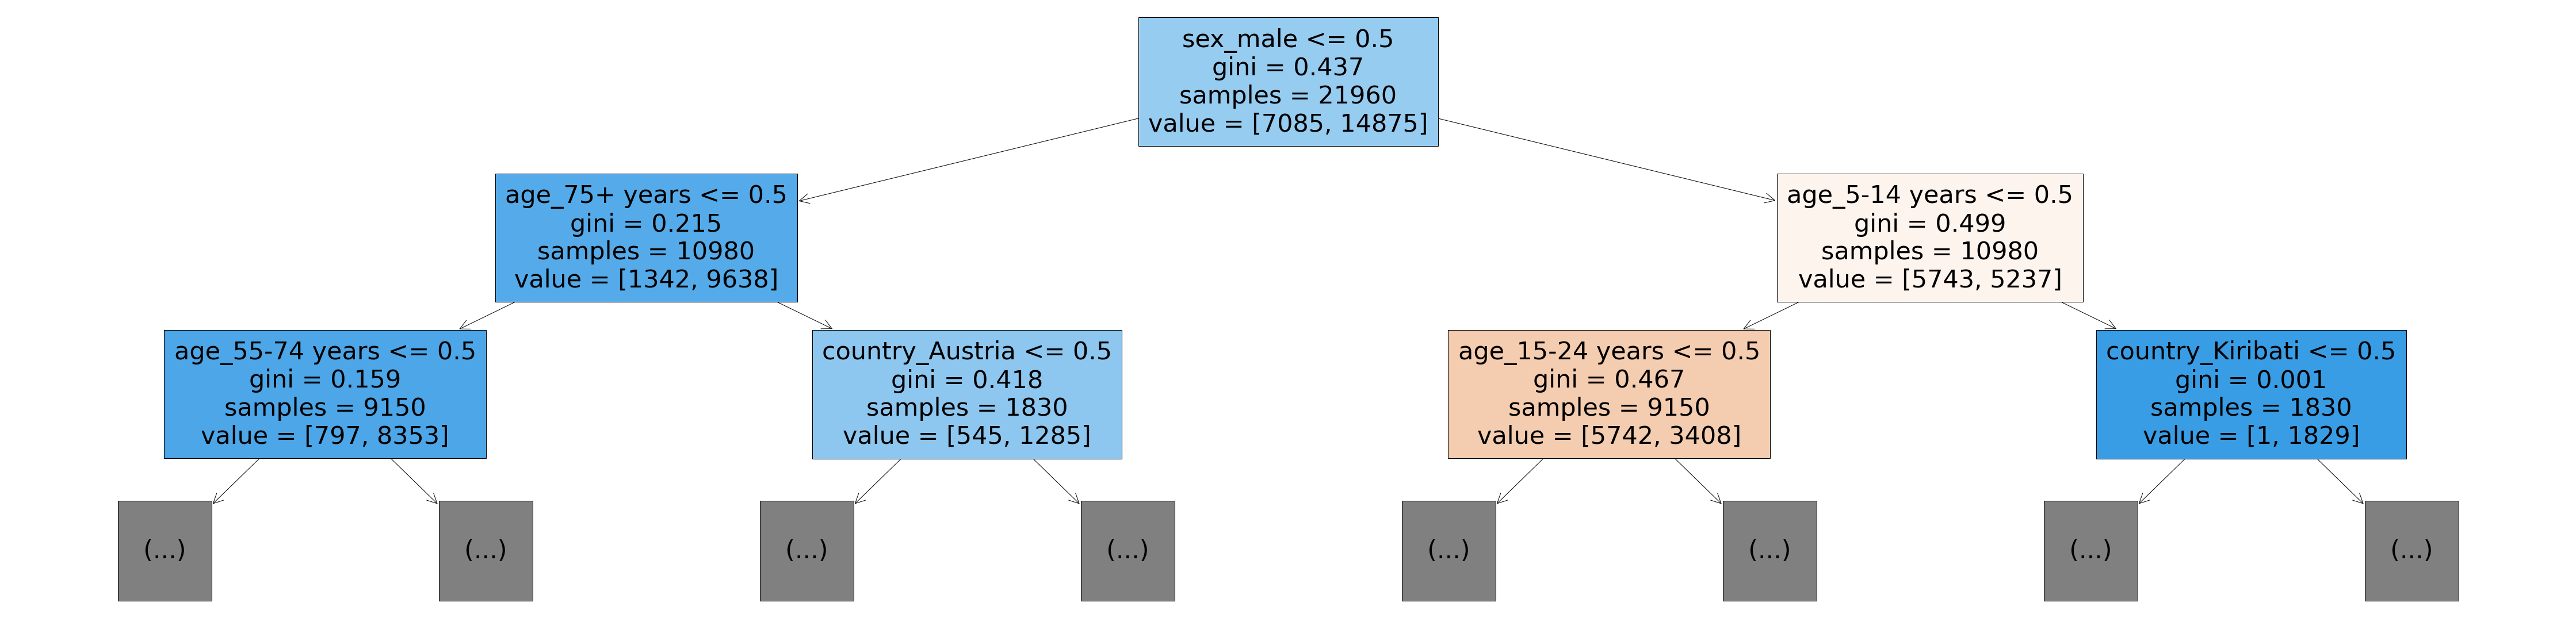

In [22]:
from sklearn.tree import plot_tree

plt.figure(figsize=(80, 20))
plot_tree(tree, feature_names=X_train.columns, max_depth=2, filled=True);

#### Feature Importance
SK Learn's Decision Tree classifier has a built-in function that allows us to examine the importance of each feature via the Gini index. 

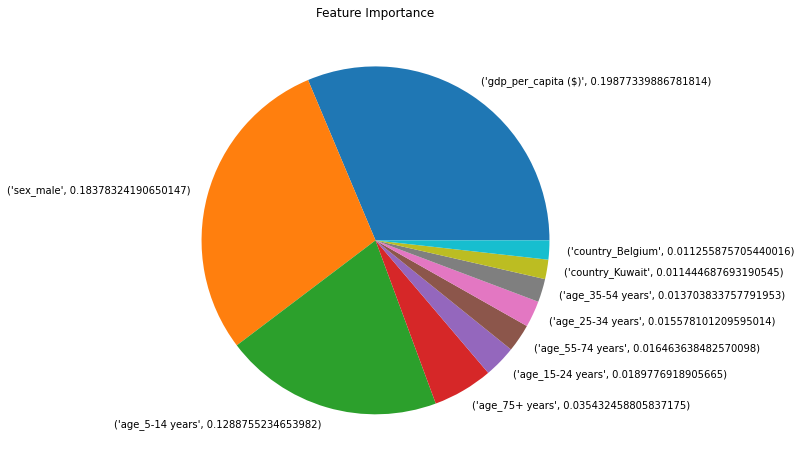

In [23]:
plt.figure(figsize=(10, 8));
importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': tree.feature_importances_}).sort_values(by='importance', ascending=False)

# Representation of feature importance in a pie chart 
labels = list(zip(importance['feature'].head(10).values, importance['importance'].head(10).values))
plt.pie(x=importance['importance'].head(10), labels=labels );
plt.title("Feature Importance");

The features with the most influence when predicting a high or low suicide risk are gdp_per_capita, sex_male, and age_5-14_years. Referring back to the age and gender distribution bar chart from the exploratory data analysis, it is clear to see that males have a higher amount of suicides than females. Also note that the 5-14 age group has the fewest amount of suicides. The 4th highest importance feature is also noteworthy, age_75+_ years, because it is the age group with the highest risk. 

### Hyperparameter Tuning

Let's look at the hyperparameters max_depth and min_samples_split. Max_depth determines the maximum tree height, or in other words how complex the decision tree is. The deeper the tree the closer it gets to being overfitted. Min_samples_split is the minimum number of samples required to split an internal node.

#### Max Tree Depth

In [24]:
# Current max_depth of tree
tree.tree_.max_depth

69

In [25]:
# Let's test from a minimum depth of 2, incrementing by 2 to 42 
acc_results = []

for depth in range(2, 43, 2):
    tree = DecisionTreeClassifier(random_state=1, max_depth=depth)
    tree.fit(X_train, train_target)
    
    train_pred = tree.predict(X_train)
    val_pred = tree.predict(X_val)
    
    train_acc = accuracy_score(train_target, train_pred)
    val_acc = accuracy_score(val_target, val_pred)
    
    acc_results.append({'max_depth': depth, 'train_acc': train_acc, 'val_acc':val_acc})

In [26]:
# Creating a dataframe from accuracy results for ease of plotting
acc_df = pd.DataFrame(data=acc_results)

# Find best accuracy value and location
best_depth = acc_df['val_acc'].max()
bd_loc = acc_df['val_acc'].idxmax()

train_loc = acc_df['train_acc'][bd_loc]

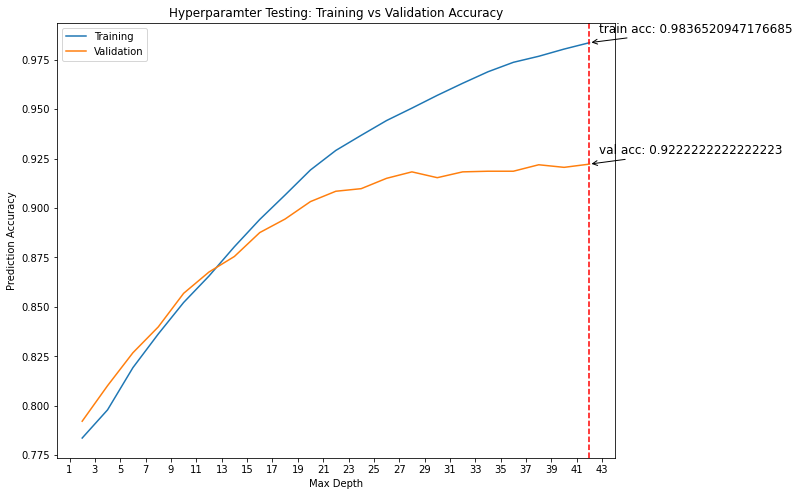

In [27]:
# Create a line plot to visualize training error and validation error against max_depth
plt.figure(figsize=(10, 8));
#fig, ax = plt.subplots();
# sns.lineplot(data=acc_df, x='max_depth', y='train_acc', ax=ax);
# sns.lineplot(data=acc_df, x='max_depth', y='val_acc', ax=ax);

plt.plot(acc_df['max_depth'], acc_df['train_acc']);
plt.plot(acc_df['max_depth'], acc_df['val_acc']);
plt.ylabel('Prediction Accuracy');
plt.xlabel('Max Depth')
plt.xticks(range(1, 44, 2));
plt.title('Hyperparamter Testing: Training vs Validation Accuracy');
plt.legend(['Training', 'Validation']);

# Annotate the training error and validation error 
plt.axvline(x=(bd_loc+1) * 2, color='r', linestyle='--');
plt.annotate(f'val acc: {best_depth}',
            xy=((bd_loc+1) * 2, best_depth),
            xycoords='data',
            fontsize=12,
            xytext=(10, 10),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black',
                            connectionstyle="arc3"));
plt.annotate(f'train acc: {train_loc}',
            xy=((bd_loc+1) * 2, acc_df['train_acc'][bd_loc]),
            xycoords='data',
            fontsize=12,
            xytext=(10, 10),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black',
                            connectionstyle="arc3"));
plt.show();


The best accuracy on the validation set is at max_depth = 38. Let's use this value versus the probably overfitted value of 69. The accuracy is still very good at ~92% as opposed to ~93% before.

#### Minimum Samples Split
As mentioned earlier, the min_samples_split is the minimum number of samples in an internal node that is required to split that node. Gini impurity is used to calculate how "pure" a node is, that is how many samples are in the node upon creation of the node. The formula is denoted by 

![G = 1 - summation from k = 1 to n of p sub k squared](https://miro.medium.com/max/466/1*UNszwSYfUJFHtfC0jvBKsw@2x.png)

where p[k] is the fraction of samples belonging to class k. 

Sklearn's GridSearchCV function helps automate the process of finding the best combination of hyperparameters by trainging a Decision Tree model on a range of max_depths and min_samples_split and keeping track of the best performers. 

In [28]:
# Create hyperparameter ranges for GridSearchCV
param_dict = {
    "max_depth": range(2, 40, 2),
    "min_samples_split": range(2, 10, 2)
}

# GSCV splits the data itself so we have to concat it back together
X = pd.concat([X_train, X_val])
Y = pd.concat([train_target, val_target])

from sklearn.model_selection import GridSearchCV

# Using the grid
# GridSearchCV returns 
tree = DecisionTreeClassifier(random_state=1)
grid = GridSearchCV(tree, param_grid=param_dict)
grid.fit(X, Y)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'max_depth': range(2, 40, 2),
                         'min_samples_split': range(2, 10, 2)})

In [29]:
# Access logs from the grid search
print('best params: ', grid.best_params_)
print('accuracy score: ', grid.best_score_)

best params:  {'max_depth': 38, 'min_samples_split': 6}
accuracy score:  0.859312549960032


In [30]:
# Test predictions on the best model determined by the grid search
test_pred = grid.predict(X_test)
accuracy_score(test_target, test_pred)

0.9225

In [31]:
val_pred = grid.predict(X_val)
accuracy_score(val_target, val_pred)

0.961437908496732

After hyperparamter tuning, the model has a significantly improved accuracy of ~96%!. Let's use the model to make some predictions.
#### Predictions
*Note: Please ignore warnings, performance was not significantly affected in the following tasks.*

In [32]:
# Create a sample input for the model to predict a high or low suicide risk
new_input = {
    'country': 'Republic of Korea',
    'year': 2020,
    'sex': 'male',
    'age': '75+ years',
    'suicides_no': 1400,
    'population': 900000,
    'suicides/100k pop': 155.55,
    'HDI for year': 0.9,
    'gdp_for_year ($)': '1,000,000,000',
    'gdp_per_capita ($)': 29000,
    'generation': 'Silent' 
}

# Encode the input to the proper format to be run in the model
input_df = pd.DataFrame([new_input])
input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
input_df[encoded_cols] = encoder.transform(input_df[categorical_cols]).toarray()

X_input = input_df[numeric_cols + encoded_cols]
pred = grid.predict(X_input)[0]
prob = grid.predict_proba(X_input)[0][list(grid.classes_).index(pred)]

/var/folders/t4/ybx0qpc17lgbs28t98mp2wk40000gn/T/ipykernel_38988/188150098.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols]).toarray()
/var/folders/t4/ybx0qpc17lgbs28t98mp2wk40000gn/T/ipykernel_38988/188150098.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols]).toarray()
/var/folders/t4/ybx0qpc17lgbs28t98mp2wk40000gn/T/ipykernel_38988/188150098.py:19: PerformanceWarning: DataFrame is h

In [33]:
print("Suicice Risk, Probability: ", pred, prob)

Suicice Risk, Probability:  high 1.0


In [34]:
# Create a sample input for the model to predict a high or low suicide risk
new_input_2 = {
    'country': 'Singapore',
    'year': 2020,
    'sex': 'female',
    'age': '15-24 years',
    'suicides_no': 14,
    'population': 250000,
    'suicides/100k pop': 5.6,
    'HDI for year': 0.7,
    'gdp_for_year ($)': '300,000,000,000',
    'gdp_per_capita ($)': 80000,
    'generation': 'Millenials' 
}

# Encode the input to the proper format to be run in the model
input_df = pd.DataFrame([new_input_2])
input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
input_df[encoded_cols] = encoder.transform(input_df[categorical_cols]).toarray()

X_input = input_df[numeric_cols + encoded_cols]
pred = grid.predict(X_input)[0]
prob = grid.predict_proba(X_input)[0][list(grid.classes_).index(pred)]

/var/folders/t4/ybx0qpc17lgbs28t98mp2wk40000gn/T/ipykernel_38988/3156601195.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols]).toarray()
/var/folders/t4/ybx0qpc17lgbs28t98mp2wk40000gn/T/ipykernel_38988/3156601195.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols]).toarray()
/var/folders/t4/ybx0qpc17lgbs28t98mp2wk40000gn/T/ipykernel_38988/3156601195.py:19: PerformanceWarning: DataFrame i

In [35]:
print("Suicide Risk, Probability: ", pred, prob)

Suicide Risk, Probability:  low 1.0


##### The model performed accurately, outputting expected results.

<a id='scratch_alg'></a>
## Decision Tree from Scratch

In [36]:
# The scratch model requires binary values for classification
# Create additional column for suicide risk and set the default value as low == 0
raw_df['suicide_risk'] = 0 

# Set the risk as high if suicides/100k pop is higher than the mean, high == 1
# Compare the value of suicides/100k to the mean of all suicides/100k.
# If the value is lower than the mean we'll say it is a low risk (0), else a high risk (1)

raw_df.loc[raw_df['suicides/100k pop'] > raw_df['suicides/100k pop'].mean(), 'suicide_risk'] = 1 
raw_df['suicide_risk'].value_counts()

0    19061
1     8759
Name: suicide_risk, dtype: int64

Since we have time series data and are attempting to build a machine learning model to make predictions on the future, we need to train the model on past observations. Therefore, instead of doing a randomized 80%|10%|10% train test validate split, we will split the data by time. By taking the cumulative sum / sum of years of all the data, we can see what percentage of the data hs been collected up until a particular year. Observe the list below: ~80% of the data represents years 1985 - 2009, the next ~10% is from 2010 - 2013, and the final ~10% from 2014 - 2016.

In [37]:
# Create a series containing number of data per year
year_dt = raw_df.year.value_counts()
year_dt.sort_index(inplace=True)
cum_pct = 100 * year_dt.cumsum() / year_dt.sum()
cum_pct

1985      2.070453
1986      4.140906
1987      6.470165
1988      8.583753
1989     10.826743
1990     13.587347
1991     16.347951
1992     19.151689
1993     21.955428
1994     24.888569
1995     28.253055
1996     31.574407
1997     34.895758
1998     38.303379
1999     41.883537
2000     45.593098
2001     49.388929
2002     53.098490
2003     56.808052
2004     60.431344
2005     64.054637
2006     67.721064
2007     71.430625
2008     75.097052
2009     78.936017
2010     82.731848
2011     86.441409
2012     89.935298
2013     93.386053
2014     96.750539
2015     99.424874
2016    100.000000
Name: year, dtype: float64

In [38]:
# Split data into 80/10/10

train_df = raw_df.loc[raw_df['year'] <= 2009]
val_df = raw_df.loc[(raw_df['year'] >= 2010) & (raw_df['year'] <=2012)]
test_df = raw_df.loc[raw_df['year'] >= 2013]

print('train_df.shape: ', train_df.shape)
print('val_df.shape: ', val_df.shape)
print('test_df.shape: ', test_df.shape)

train_df.shape:  (21960, 12)
val_df.shape:  (3060, 12)
test_df.shape:  (2800, 12)


Noting the correlellogram from earlier, the following columns won't be useful for the algorithm:
year, suicides_no, population, suicides/100k, gpd_for_year, and generation. 

In [39]:
# Label input and target columns
input_cols = ['country', 'sex', 'age', 'gdp_per_capita ($)']
target_col = 'suicide_risk'

In [40]:
train_inputs = train_df.loc[:, input_cols]
train_target = train_df.loc[:, target_col]

val_inputs = val_df.loc[:, input_cols]
val_target = val_df.loc[:, target_col]

test_inputs = test_df.loc[:, input_cols]
test_target = test_df.loc[:, target_col]


In [41]:
numeric_cols = list(train_inputs.select_dtypes(include=np.number).columns)
categorical_cols = list(train_inputs.select_dtypes(include='object').columns)

The numeric features identified in the previous step need to scaled to values from 0 to 1 to prevent particular features from having a disproportionate affect on the accuracy of the model.

In [42]:
from sklearn.preprocessing import MinMaxScaler

# Fit the scaler to all the data
scaler = MinMaxScaler().fit(raw_df.loc[:, numeric_cols])

# Scale the train, validation and test sets 
train_inputs.loc[:, numeric_cols] = scaler.transform(train_inputs.loc[:, numeric_cols])
val_inputs.loc[:, numeric_cols] = scaler.transform(val_inputs.loc[:, numeric_cols])
test_inputs.loc[:, numeric_cols] = scaler.transform(test_inputs.loc[:, numeric_cols])



In [43]:
train_inputs[numeric_cols].describe()

,gdp_per_capita ($)
count,21960.000000
mean,0.111703
std,0.126815
min,0.000000
25%,0.020373
50%,0.057252
75%,0.178032
max,0.960056


Finally, we need to encode the categorical columns into values of either 0 or 1 in order to use them in the algorithm.

In [44]:
# Check the number of unique values of each categorical column
raw_df[categorical_cols].nunique()

country    101
sex          2
age          6
dtype: int64

In [45]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore').fit(raw_df[categorical_cols])

In [46]:
encoded_cols = list(encoder.get_feature_names(categorical_cols))

# Encode the columns
train_inputs[encoded_cols] = encoder.transform(train_inputs.loc[:, categorical_cols]).toarray()
val_inputs[encoded_cols] = encoder.transform(val_inputs.loc[:, categorical_cols]).toarray()
test_inputs[encoded_cols] = encoder.transform(test_inputs.loc[:, categorical_cols]).toarray()

/opt/homebrew/Caskroom/miniforge/base/envs/env-01/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/var/folders/t4/ybx0qpc17lgbs28t98mp2wk40000gn/T/ipykernel_38988/2917261160.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs.loc[:, categorical_cols]).toarray()
/var/folders/t4/ybx0qpc17lgbs28t98mp2wk40000gn/T/ipykernel_38988/2917261160.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

In [47]:
train_inputs

,country,sex,age,gdp_per_capita ($),country_Albania,country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Aruba,country_Australia,...,country_Uruguay,country_Uzbekistan,sex_female,sex_male,age_15-24 years,age_25-34 years,age_35-54 years,age_5-14 years,age_55-74 years,age_75+ years
0,Albania,male,15-24 years,0.004322,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Albania,male,35-54 years,0.004322,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Albania,female,15-24 years,0.004322,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,Albania,male,75+ years,0.004322,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Albania,male,25-34 years,0.004322,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27755,Uzbekistan,female,75+ years,0.008572,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27756,Uzbekistan,female,35-54 years,0.008572,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
27757,Uzbekistan,female,55-74 years,0.008572,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
27758,Uzbekistan,male,5-14 years,0.008572,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [48]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

### Decison Tree from scratch

In [49]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        
    def debug(self, feature_names, class_names, show_details=True):
        """Print ASCII visualization of decision tree."""
        self.tree_.debug(feature_names, class_names, show_details)

    def _gini(self, y):
        """Compute Gini impurity of a non-empty node.
        Gini impurity is defined as Σ p(1-p) over all classes, with p the frequency of a
        class within the node. Since Σ p = 1, this is equivalent to 1 - Σ p^2.
        """
        m = y.size
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in range(self.n_classes_))

    def _best_split(self, X, y):
        """Find the best split for a node.
        "Best" means that the average impurity of the two children, weighted by their
        population, is the smallest possible. Additionally it must be less than the
        impurity of the current node.
        To find the best split, we loop through all the features, and consider all the
        midpoints between adjacent training samples as possible thresholds. We compute
        the Gini impurity of the split generated by that particular feature/threshold
        pair, and return the pair with smallest impurity.
        Returns:
            best_idx: Index of the feature for best split, or None if no split is found.
            best_thr: Threshold to use for the split, or None if no split is found.
        """
        # Need at least two elements to split a node.
        m = y.size
        if m <= 1:
            return None, None

        # Count of each class in the current node.
        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]

        # Gini of current node.
        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
        best_idx, best_thr = None, None

        # Loop through all features.
        for idx in range(self.n_features_):
            # Sort data along selected feature.
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))

            # We could actually split the node according to each feature/threshold pair
            # and count the resulting population for each class in the children, but
            # instead we compute them in an iterative fashion, making this for loop
            # linear rather than quadratic.
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, m):  # possible split positions
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes_)
                )
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
                )

                # The Gini impurity of a split is the weighted average of the Gini
                # impurity of the children.
                gini = (i * gini_left + (m - i) * gini_right) / m

                # The following condition is to make sure we don't try to split two
                # points with identical values for that feature, as it is impossible
                # (both have to end up on the same side of a split).
                if thresholds[i] == thresholds[i - 1]:
                    continue

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2  # midpoint

        return best_idx, best_thr
    
    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _predict(self, inputs):
        """Predict class for a single sample."""
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class
    
    def fit(self, X, y):
        """Build decision tree classifier."""
        self.n_classes_ = len(set(y))  # classes are assumed to go from 0 to n-1
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        """Build a decision tree by recursively finding the best split."""
        # Population for each class in current node. The predicted class is the one with
        # largest population.
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(
            gini=self._gini(y),
            num_samples=y.size,
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class,
        )

        # Split recursively until maximum depth is reached.
        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node
    
class Node:
    def __init__(self, gini, num_samples, num_samples_per_class, predicted_class):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None
     
    def debug(self, feature_names, class_names, show_details):
        """Print an ASCII visualization of the tree."""
        lines, _, _, _ = self._debug_aux(
            feature_names, class_names, show_details, root=True
        )
        for line in lines:
            print(line)

    def _debug_aux(self, feature_names, class_names, show_details, root=False):
        # See https://stackoverflow.com/a/54074933/1143396 for similar code.
        is_leaf = not self.right
        if is_leaf:
            lines = [class_names[self.predicted_class]]
        else:
            lines = [
                "{} < {:.2f}".format(feature_names[self.feature_index], self.threshold)
            ]
        if show_details:
            lines += [
                "gini = {:.2f}".format(self.gini),
                "samples = {}".format(self.num_samples),
                str(self.num_samples_per_class),
            ]
        width = max(len(line) for line in lines)
        height = len(lines)
        if is_leaf:
            lines = ["║ {:^{width}} ║".format(line, width=width) for line in lines]
            lines.insert(0, "╔" + "═" * (width + 2) + "╗")
            lines.append("╚" + "═" * (width + 2) + "╝")
        else:
            lines = ["│ {:^{width}} │".format(line, width=width) for line in lines]
            lines.insert(0, "┌" + "─" * (width + 2) + "┐")
            lines.append("└" + "─" * (width + 2) + "┘")
            lines[-2] = "┤" + lines[-2][1:-1] + "├"
        width += 4  # for padding

        if is_leaf:
            middle = width // 2
            lines[0] = lines[0][:middle] + "╧" + lines[0][middle + 1 :]
            return lines, width, height, middle

        # If not a leaf, must have two children.
        left, n, p, x = self.left._debug_aux(feature_names, class_names, show_details)
        right, m, q, y = self.right._debug_aux(feature_names, class_names, show_details)
        top_lines = [n * " " + line + m * " " for line in lines[:-2]]
        # fmt: off
        middle_line = x * " " + "┌" + (n - x - 1) * "─" + lines[-2] + y * "─" + "┐" + (m - y - 1) * " "
        bottom_line = x * " " + "│" + (n - x - 1) * " " + lines[-1] + y * " " + "│" + (m - y - 1) * " "
        # fmt: on
        if p < q:
            left += [n * " "] * (q - p)
        elif q < p:
            right += [m * " "] * (p - q)
        zipped_lines = zip(left, right)
        lines = (
            top_lines
            + [middle_line, bottom_line]
            + [a + width * " " + b for a, b in zipped_lines]
        )
        middle = n + width // 2
        if not root:
            lines[0] = lines[0][:middle] + "┴" + lines[0][middle + 1 :]
        return lines, n + m + width, max(p, q) + 2 + len(top_lines), middle

In [50]:
# Convert dataframes to numpy arrays for decision tree from scratch
X_train_np = X_train.to_numpy()
X_val_np = X_val.to_numpy()
X_test_np = X_test.to_numpy()

train_target_np = train_target.to_numpy()
val_target_np = val_target.to_numpy()
test_target_np = test_target.to_numpy()

In [51]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

/var/folders/t4/ybx0qpc17lgbs28t98mp2wk40000gn/T/ipykernel_38988/2650430601.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Create and train a decision tree model. Used a function from stack overflow to visualize the data. We can observe similar results to the sklearn implementation.

In [52]:
## Train decision tree model

tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_train_np, train_target_np)

# Visualize.
tree.debug(
    feature_names=["{} ".format(X_train.columns[i]) for i in range(0, 110)],
    class_names=["Suicide Risk {}".format(i) for i in range(0, 2)],
)

                                                              ┌────────────────────┐                                                             
                                                              │ sex_female  < 0.50 │                                                             
                                                              │    gini = 0.44     │                                                             
                                                              │  samples = 21960   │                                                             
                               ┌──────────────────────────────┤   [14875, 7085]    ├──────────────────────────────┐                              
                               │                              └────────────────────┘                              │                              
                  ┌────────────┴───────────┐                                                          ┌───────────┴─────────

Compute accuracy for train, test and validate.

In [53]:
## Accuracy for train set
train_pred = tree.predict(X_train_np)
total = len(train_pred)
correct = 0

for i in range(0, total):
    if train_pred[i] == train_target_np[i]:
        correct += 1

print(f"Accuracy = {correct/total}")

Accuracy = 0.7836520947176685


In [54]:
## Accuracy for val set
pred2 = tree.predict(X_val_np)

total = len(pred2)
correct = 0

for i in range(0, total):
    if pred2[i] == val_target_np[i]:
        correct += 1

print(f"Accuracy = {correct/total}")

Accuracy = 0.792156862745098


In [55]:
## Accuracy for test set
pred3 = tree.predict(X_test_np)

total = len(pred3)
correct = 0

for i in range(0, total):
    if pred3[i] == test_target_np[i]:
        correct += 1

print(f"Accuracy = {correct/total}")

Accuracy = 0.7946428571428571


### Hyperparameter Tuning
Let's see if we can improve the model's accuracy by doing hyperparamter testing on the max tree depth. A tree that is too deep will be overfitted.

In [56]:
# Hyperparamter testing
# We learned from the scikit learn decision tree that the max depth is 69, which is overfitted
# Let's test from a minimum depth of 2, incrementing by 2 to 42 to see the best accuracy
import time

train_accuracy_list = []
val_accuracy_list = []
fit_time = []
train_pred_time = []
val_pred_time = []

for i in range(2, 43, 2):
    # fit tree on train
    start = time.perf_counter()
    tree = DecisionTreeClassifier(max_depth=i)
    tree.fit(X_train_np, train_target_np)
    end = time.perf_counter()
    fit_time.append(end - start);
    
    # predict on train
    start = time.perf_counter()
    train_pred = tree.predict(X_train_np)
    end = time.perf_counter()
    train_pred_time.append(end - start);
    
    # predict on val
    start = time.perf_counter()
    val_pred = tree.predict(X_val_np)
    end = time.perf_counter()
    val_pred_time.append(end - start);
    
    # calculate train accuracy
    total = len(train_pred)
    correct = 0

    for i in range(0, total):
        if train_pred[i] == train_target_np[i]:
            correct += 1

    train_accuracy_list.append(correct/total)
    
    # calculate val accuracy
    total = len(val_pred)
    correct = 0

    for i in range(0, total):
        if val_pred[i] == val_target_np[i]:
            correct += 1

    val_accuracy_list.append(correct/total)


KeyboardInterrupt: 

In [ ]:
# Find max 
maximum = max(val_accuracy_list)
pos = val_accuracy_list.index(maximum)
print(f"Tree depth with highest accuracy on validate = {(pos + 1)*2}, accuracy = {maximum}")

Tree depth with highest accuracy on validate = 42, accuracy = 0.923202614379085


In [ ]:
print(f"Training accuracy at {(pos + 1)*2} = {train_accuracy_list[pos]}")


Training accuracy at 42 = 0.9829234972677595


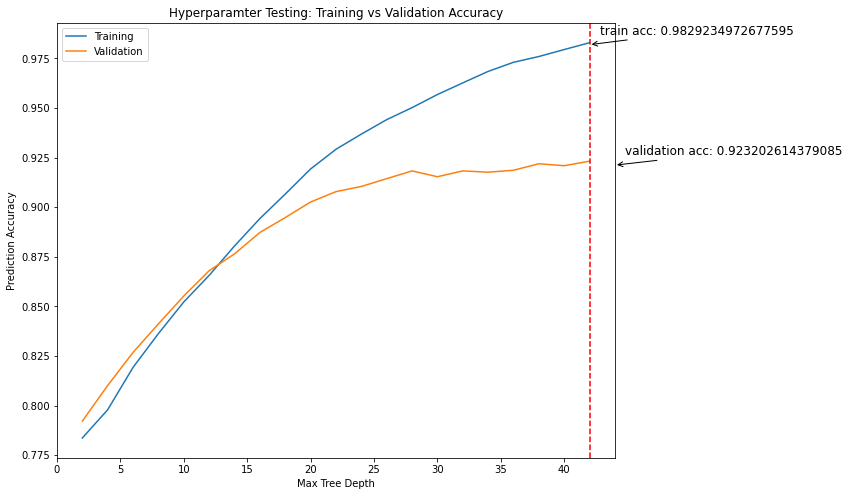

In [ ]:
plt.figure(figsize=(10, 8))

x_ticks = list(range(2, 43, 2))
plt.plot(x_ticks, train_accuracy_list);
plt.plot(x_ticks, val_accuracy_list);

# Annotate the training error and validation error 
plt.axvline(x=(pos + 1)*2, color='r', linestyle='--')
plt.annotate(f'validation acc: {val_accuracy_list[pos]}',
            xy=((pos + 2)*2, val_accuracy_list[pos] - .002),
            xycoords='data',
            fontsize=12,
            xytext=(10, 10),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black',
                            connectionstyle="arc3"));
plt.annotate(f'train acc: {train_accuracy_list[pos]}',
            xy=((pos + 1)*2, train_accuracy_list[pos]-.001),
            xycoords='data',
            fontsize=12,
            xytext=(10, 10),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black',
                            connectionstyle="arc3"));
plt.title("Hyperparamter Testing: Training vs Validation Accuracy");
plt.ylabel('Prediction Accuracy');
plt.xlabel('Max Tree Depth');
plt.legend(['Training', 'Validation']);

In the graph above we can clearly see that the accuracy increases (error decreases) as the depth increases. However, the graph below shows the performance hit taken in respect to tree depth.

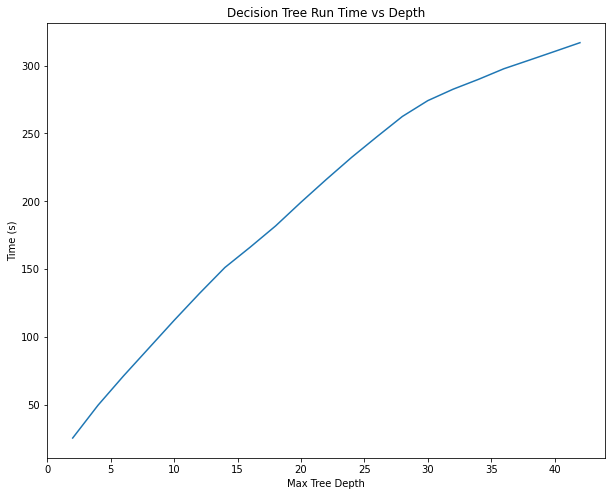

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Decision Tree Run Time vs Depth")
plt.ylabel('Time (s)');
plt.xlabel('Max Tree Depth');
x_ticks = list(range(2, 43, 2))
plt.plot(x_ticks, fit_time);

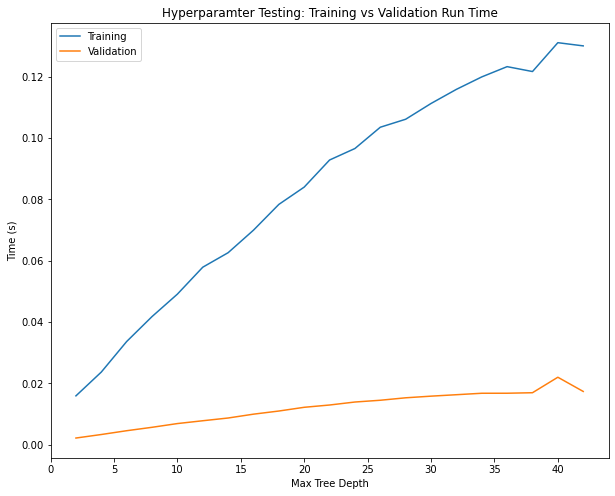

In [ ]:
plt.figure(figsize=(10, 8))

x_ticks = list(range(2, 43, 2))
#plt.plot(x_ticks, fit_time);
plt.plot(x_ticks, train_pred_time);
plt.plot(x_ticks, val_pred_time);
plt.title("Hyperparamter Testing: Training vs Validation Run Time");
# plt.ylabel('Prediction Accuracy');
# plt.xlabel('Max Tree Depth');
plt.legend(['Training', 'Validation']);
plt.ylabel('Time (s)');
plt.xlabel('Max Tree Depth');
plt.show();

Let's check the accuracy of a model with a depth of 25, since that is a reasonable run time on train (approximately 2.5 minutes), and that is where the validation accuracy seems to begin to level off. 

In [ ]:
# Let't train a new model with the max tree depth of 28
tree2 = DecisionTreeClassifier(max_depth=28)
tree2.fit(X_train_np, train_target_np)

In [ ]:
## Accuracy for train set
train_pred = tree2.predict(X_train_np)
total = len(train_pred)
correct = 0

for i in range(0, total):
    if train_pred[i] == train_target_np[i]:
        correct += 1

print(f"Accuracy = {correct/total}")

Accuracy = 0.9501821493624772


In [ ]:
## Accuracy for val set
pred2 = tree2.predict(X_val_np)

total = len(pred2)
correct = 0

for i in range(0, total):
    if pred2[i] == val_target_np[i]:
        correct += 1

print(f"Accuracy = {correct/total}")

Accuracy = 0.9183006535947712


In [ ]:
## Accuracy for test set
pred3 = tree2.predict(X_test_np)

total = len(pred3)
correct = 0

for i in range(0, total):
    if pred3[i] == test_target_np[i]:
        correct += 1

print(f"Accuracy = {correct/total}")

Accuracy = 0.9128571428571428


### Using model to make predictions
Finally, let's use the model to make some predictions. The first input should output a class of 1, signifiying a high suicide risk individual. The second prediction should result in an output of 0 for a low suicide risk individual. 

In [ ]:
# Create test input for prediction, hypothesis: high risk (1)
test_input = {
  'country': ['Republic of Korea'],
    'year': [2020],
    'sex': ['male'],
    'age': ['75+ years'],
    'suicides_no': [1400],
    'population': [900000],
    'suicides/100k pop': [155.55],
    'gdp_for_year ($)': ['1,000,000,000'],
    'gdp_per_capita ($)': [29000] 
}

input_df = pd.DataFrame(test_input)
input_df['age'][0]

country_label = ['country_' + input_df['country'][0]]
sex_label = ['sex_' + input_df['sex'][0]]
age_label = ['age_' + input_df['age'][0]]

#train_inputs.loc[train_inputs['age'] == input_df['age'][0]]

# Use data from X_val to get the most similar entry and format input using those values
norm_input = X_val.loc[(X_val[country_label[0]] ==  1) & (X_val[sex_label[0]] == 1) 
                               & (X_val[age_label[0]] == 1)]

# Get most recent entry matching the important features
test_input = norm_input.iloc[-1]

test_input = test_input.to_numpy()

test_input

pred = tree2.predict([test_input])[0]
print("Prediction for input: ", pred )

Prediction for input:  1


In [ ]:
# Create test input for prediction,  hypothesis: low risk (0)
test_input = {
  'country': ['Singapore'],
    'year': [2020],
    'sex': ['female'],
    'age': ['15-24 years'],
    'suicides_no': [14],
    'population': [250000],
    'suicides/100k pop': [5.6],
    'gdp_for_year ($)': ['300,000,000,000'],
    'gdp_per_capita ($)': [80000] 
}

input_df = pd.DataFrame(test_input)
input_df['age'][0]

country_label = ['country_' + input_df['country'][0]]
sex_label = ['sex_' + input_df['sex'][0]]
age_label = ['age_' + input_df['age'][0]]

# Use data from X_val to get the most similar entry and format input using those values
norm_input = X_val.loc[(X_val[country_label[0]] ==  1) & (X_val[sex_label[0]] == 1) 
                               & (X_val[age_label[0]] == 1)]

# Get most recent entry matching the important features
test_input = norm_input.iloc[-1]

test_input = test_input.to_numpy()

test_input

pred = tree2.predict([test_input])[0]
print("Prediction for input: ", pred )

Prediction for input:  0


##### The model performed accurately, outputting expected results.

<a id='analysis'></a>
# Analysis of SK Learn vs Scratch Implemenation


Let's compare the testing and results from each of the implementations. 

### 7) Learning Curves and Accuracy

Prior to hyperparameter testing, we can see that the sk learn model is more accurate:

sk:<br>
train = 1.0<br>
test = 0.9182142857142858<br>
val = 0.9316993464052288<br>

scratch:<br>
train = 0.7836520947176685<br>test = 0.7946428571428571<br>val = 0.7946428571428571

The SK learn model allows tuning on max_depth and min_samples_split.
The scratch model only allows hyperparameter tuning on 1 parameter, max_depth, because it uses a best_split() function that determines the minimal Gini impurity.

#### SK Learn
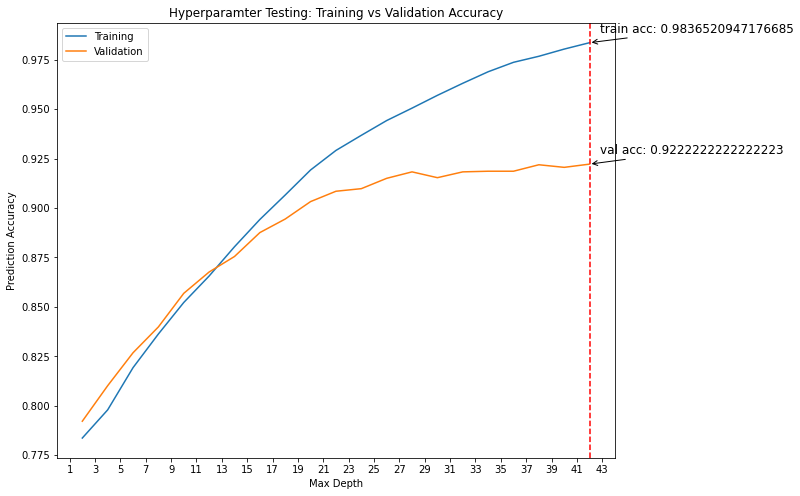

#### Scratch
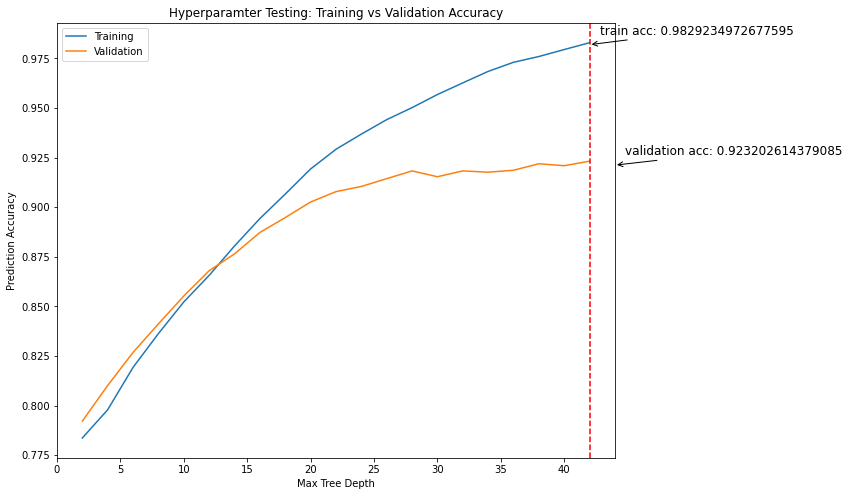

After hyperparameter testing, we can see that the sk learn and scratch models have similar learning curves, as well as accuracy at max_depth = 42. However, these parameters are prone to overfitting.
<br><br>
The sk learn model's ideal hyperparameters of max_depth = 38 and min_samples_split = 6.
<br>train = 0.859312549960032 <br>test = 0.9225<br>val = 0.961437908496732 <br><br>
The scratch model ideal hyperparameter is a max_depth of 28.
<br>train = 0.9501821493624772 <br>test = 0.9128571428571428<br>val = 0.9183006535947712 <br><br>
The sk learn model's train accuracy decreased, which is good in this case because it is no longer overfitted. The test and validate accuracies have improved by approximately 1% and 3% respectively.
<br>
The scratch model increased accuracy dramatically, by about 12% for all sets.

### Dimension Restriction
Let's test the accuracy when dropping the 'age' column on the SK Learn model. 
<br>*Note: The scratch model had a lot of bugs when attempting to restrict it, so only the sk learn was used for this section.*

In [ ]:
# Data preprocessing

# Read in data
raw_df_2 = pd.read_csv('./data/master.csv')

# Remove whitespaces
raw_df_2.rename(columns={' gdp_for_year ($) ':'gdp_for_year ($)'}, inplace=True)

# # Drop na values in HDI
raw_df_2.loc[raw_df['HDI for year'].isna(), ['country', 'year']].drop_duplicates()


# # Decided to drop column so as to not skew results due to missing information in some rows
raw_df_2.drop(["HDI for year"], axis=1, inplace=True)
raw_df_2.drop(["age"], axis=1,inplace=True)

# # Create additional column for suicide risk
raw_df_2['suicide_risk'] = 0 
raw_df_2.loc[raw_df_2['suicides/100k pop'] > raw_df_2['suicides/100k pop'].mean(), 'suicide_risk'] = 1 

# Split train, test, val
train_df_2 = raw_df_2.loc[raw_df_2['year'] <= 2004]
val_df_2 = raw_df_2.loc[(raw_df_2['year'] >= 2005) & (raw_df_2['year'] <=2010)]
test_df_2 = raw_df_2.loc[raw_df_2['year'] >= 2011]

# Assign input and target columns
input_cols_2 = ['country', 'sex', 'gdp_per_capita ($)']
target_col_2 = 'suicide_risk'

train_inputs_2 = train_df_2.loc[:, input_cols_2]
train_target_2 = train_df_2.loc[:, target_col_2]

val_inputs_2 = val_df_2.loc[:, input_cols_2]
val_target_2 = val_df_2.loc[:, target_col_2]

test_inputs_2 = test_df_2.loc[:, input_cols_2]
test_target_2 = test_df_2.loc[:, target_col_2]

# ID numeric and categorical columns
numeric_cols_2 = list(train_inputs_2.select_dtypes(include=np.number).columns)
categorical_cols_2 = list(train_inputs_2.select_dtypes(include='object').columns)

# Fit the scaler to all the data
scaler_2 = MinMaxScaler().fit(raw_df_2.loc[:, numeric_cols_2])

# Scale the train, validation and test sets 
train_inputs_2.loc[:, numeric_cols_2] = scaler_2.transform(train_inputs_2.loc[:, numeric_cols_2])
val_inputs_2.loc[:, numeric_cols_2] = scaler_2.transform(val_inputs_2.loc[:, numeric_cols_2])
test_inputs_2.loc[:, numeric_cols_2] = scaler_2.transform(test_inputs_2.loc[:, numeric_cols_2])

# Check the number of unique values of each categorical column
raw_df_2[categorical_cols_2].nunique()

# # Encode categorical columns
encoder_2 = OneHotEncoder(handle_unknown='ignore').fit(raw_df_2[categorical_cols_2])

# # Generate columns names and add to inputs arrays
encoded_cols_2 = list(encoder_2.get_feature_names(categorical_cols_2))

# # Encode the columns
train_inputs_2[encoded_cols_2] = encoder_2.transform(train_inputs_2.loc[:, categorical_cols_2]).toarray()
val_inputs_2[encoded_cols_2] = encoder_2.transform(val_inputs_2.loc[:, categorical_cols_2]).toarray()
test_inputs_2[encoded_cols_2] = encoder_2.transform(test_inputs_2.loc[:, categorical_cols_2]).toarray()

X_train_2 = train_inputs_2[numeric_cols_2 + encoded_cols_2]
X_val_2 = val_inputs_2[numeric_cols_2 + encoded_cols_2]
X_test_2 = test_inputs_2[numeric_cols_2 + encoded_cols_2]

C:\Users\Travis\anaconda3\envs\geo_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Travis\AppData\Local\Temp\ipykernel_21024\2086716115.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs_2[encoded_cols_2] = encoder_2.transform(train_inputs_2.loc[:, categorical_cols_2]).toarray()
C:\Users\Travis\AppData\Local\Temp\ipykernel_21024\2086716115.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

In [ ]:
# Let's use the decision tree from sk learn
from sklearn.tree import DecisionTreeClassifier as sk_dt

tree_3 = sk_dt(random_state=1, max_depth = 38, min_samples_split = 6)
tree_3.fit(X_train_2, train_target_2)

DecisionTreeClassifier(max_depth=38, min_samples_split=6, random_state=1)

In [ ]:
train_pred_2 = tree_3.predict(X_train_2)
accuracy_score(train_target_2, train_pred_2)

0.8269688317868189

In [ ]:
# Test predictions on the best model determined by the grid search
test_pred_2 = tree_3.predict(X_test_2)
accuracy_score(test_target_2, test_pred_2)

0.8105745212323064

In [ ]:
val_pred_2 = tree_3.predict(X_val_2)
accuracy_score(val_target_2, val_pred_2)

0.8152804642166345

In [ ]:
# Convert dataframes to numpy arrays for decision tree from scratch
X_train_np_2 = X_train_2.to_numpy()
X_val_np_2 = X_val_2.to_numpy()
X_test_np_2 = X_test_2.to_numpy()

train_target_np_2 = train_target_2.to_numpy()
val_target_np_2 = val_target_2.to_numpy()
test_target_np_2 = test_target_2.to_numpy()

In [ ]:
# Let's train a new model with the max tree depth of 28
tree_4 = DecisionTreeClassifier(max_depth=28)
tree_4.fit(X_train_np_2, train_target_np_2)

In [ ]:
## Accuracy for train set
train_pred_2 = tree_4.predict(X_train_np_2)
total = len(train_pred_2)
correct = 0

for i in range(0, total):
    if train_pred_2[i] == train_target_np_2[i]:
        correct += 1

print(f"Accuracy = {correct/total}")

Accuracy = 0.8149536045681656


In [ ]:
## Accuracy for train set
test_pred_2 = tree_4.predict(X_test_np_2)
total = len(test_pred_2)
correct = 0

for i in range(0, total):
    if test_pred_2[i] == test_target_np_2[i]:
        correct += 1

print(f"Accuracy = {correct/total}")

Accuracy = 0.8136969192339717


In [ ]:
## Accuracy for train set
val_pred_2 = tree_4.predict(X_val_np_2)
total = len(val_pred_2)
correct = 0

for i in range(0, total):
    if train_pred_2[i] == val_target_np_2[i]:
        correct += 1

print(f"Accuracy = {correct/total}")

Accuracy = 0.6882656350741457


As we can see, in both models the accuracy has significantly dropped, by about -10% for most sets and by -20% for the validate set on the scratch model. 

### Hypothesis testing
After doing the EDA and model testing, we have hypothesized that out of the most influential features, sex and age, the sample group 'male' and '75+ years' is the most at risk population.

#### Using model to make predictions
Finally, let's use the model to make some predictions. The first input should output a class of 1, signifiying a high suicide risk individual. The second prediction should result in an output of 0 for a low suicide risk individual. 

#### Scratch Model Predictions:

In [ ]:
# Using scratch model to make prediction# Create test input for prediction,  hypothesis: low risk (0)
# Create test input for prediction, hypothesis: high risk (1)
test_input = {
  'country': ['Republic of Korea'],
    'year': [2020],
    'sex': ['male'],
    'age': ['75+ years'],
    'suicides_no': [1400],
    'population': [900000],
    'suicides/100k pop': [155.55],
    'gdp_for_year ($)': ['1,000,000,000'],
    'gdp_per_capita ($)': [29000] 
}

input_df = pd.DataFrame(test_input)
input_df['age'][0]

country_label = ['country_' + input_df['country'][0]]
sex_label = ['sex_' + input_df['sex'][0]]
age_label = ['age_' + input_df['age'][0]]

#train_inputs.loc[train_inputs['age'] == input_df['age'][0]]

# Use data from X_val to get the most similar entry and format input using those values
norm_input = X_val.loc[(X_val[country_label[0]] ==  1) & (X_val[sex_label[0]] == 1) 
                               & (X_val[age_label[0]] == 1)]

# Get most recent entry matching the important features
test_input = norm_input.iloc[-1]

test_input = test_input.to_numpy()

test_input

pred = tree2.predict([test_input])[0]
print("Prediction for input: ", pred )

Prediction for input:  1


In [ ]:
# Create test input for prediction, hypothesis: low risk (0)
test_input = {
  'country': ['Singapore'],
    'year': [2020],
    'sex': ['female'],
    'age': ['15-24 years'],
    'suicides_no': [14],
    'population': [250000],
    'suicides/100k pop': [5.6],
    'gdp_for_year ($)': ['300,000,000,000'],
    'gdp_per_capita ($)': [80000] 
}

input_df = pd.DataFrame(test_input)
input_df['age'][0]

country_label = ['country_' + input_df['country'][0]]
sex_label = ['sex_' + input_df['sex'][0]]
age_label = ['age_' + input_df['age'][0]]

# Use data from X_val to get the most similar entry and format input using those values
norm_input = X_val.loc[(X_val[country_label[0]] ==  1) & (X_val[sex_label[0]] == 1) 
                               & (X_val[age_label[0]] == 1)]

# Get most recent entry matching the important features
test_input = norm_input.iloc[-1]

test_input = test_input.to_numpy()

test_input

pred = tree2.predict([test_input])[0]
print("Prediction for input: ", pred )

Prediction for input:  0


#### SK Learn Model Predictions

In [ ]:
# Create a sample input for the model to predict a high or low suicide risk - expected output 'high'
new_input = {
    'country': 'Republic of Korea',
    'year': 2020,
    'sex': 'male',
    'age': '75+ years',
    'suicides_no': 1400,
    'population': 900000,
    'suicides/100k pop': 155.55,
    'HDI for year': 0.9,
    'gdp_for_year ($)': '1,000,000,000',
    'gdp_per_capita ($)': 29000,
    'generation': 'Silent' 
}

# Encode the input to the proper format to be run in the model
input_df = pd.DataFrame([new_input])
input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
input_df[encoded_cols] = encoder.transform(input_df[categorical_cols]).toarray()

X_input = input_df[numeric_cols + encoded_cols]
pred = grid.predict(X_input)[0]
prob = grid.predict_proba(X_input)[0][list(grid.classes_).index(pred)]

C:\Users\Travis\AppData\Local\Temp\ipykernel_21024\188150098.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols]).toarray()
C:\Users\Travis\AppData\Local\Temp\ipykernel_21024\188150098.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols]).toarray()
C:\Users\Travis\AppData\Local\Temp\ipykernel_21024\188150098.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

In [ ]:
print("Suicice Risk, Probability: ", pred, prob)

Suicice Risk, Probability:  high 1.0


In [ ]:
# Create a sample input for the model to predict a high or low suicide risk, expected output 'low'
new_input_2 = {
    'country': 'Singapore',
    'year': 2020,
    'sex': 'female',
    'age': '15-24 years',
    'suicides_no': 14,
    'population': 250000,
    'suicides/100k pop': 5.6,
    'HDI for year': 0.7,
    'gdp_for_year ($)': '300,000,000,000',
    'gdp_per_capita ($)': 80000,
    'generation': 'Millenials' 
}

# Encode the input to the proper format to be run in the model
input_df = pd.DataFrame([new_input_2])
input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
input_df[encoded_cols] = encoder.transform(input_df[categorical_cols]).toarray()

X_input = input_df[numeric_cols + encoded_cols]
pred = grid.predict(X_input)[0]
prob = grid.predict_proba(X_input)[0][list(grid.classes_).index(pred)]

C:\Users\Travis\AppData\Local\Temp\ipykernel_21024\3156601195.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols]).toarray()
C:\Users\Travis\AppData\Local\Temp\ipykernel_21024\3156601195.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols]).toarray()
C:\Users\Travis\AppData\Local\Temp\ipykernel_21024\3156601195.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

In [ ]:
print("Suicice Risk, Probability: ", pred, prob)

Suicice Risk, Probability:  low 1.0


##### Both models performed accurately, outputting expected results.
Running the sample data on both models supports the hypothesis of a high suicide risk for men 75 years and older. 
